In [1]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-

from os import path
from acoular import __file__ as bpath, MicGeom, WNoiseGenerator, PointSource,\
 Mixer, WriteH5, TimeSamples, PowerSpectra, RectGrid, SteeringVector,\
 BeamformerBase, BeamformerFunctional, BeamformerMusic, L_p, SineGenerator
from pylab import figure, plot, axis, imshow, colorbar, show
from scipy.io import wavfile

wav_temp = 'modulated_signal.wav'
wav_temp2 = 'modulated_signal_noise.wav'

class FileGenerator( SineGenerator ):
    def signal(self):
        filepath = wav_temp
        _, signal = wavfile.read(filepath)
        return signal[:self.numsamples]

class FileGenerator2( SineGenerator ):
    def signal(self):
        filepath = wav_temp2
        _, signal = wavfile.read(filepath)
        return signal[:self.numsamples]

# set up the parameters
sfreq = 51200
duration = 1
nsamples = duration*sfreq
micgeofile = 'array_9.xml'
h5savefile = 'mix_mod.h5'

# generate test data, in real life this would come from an array measurement
mg = MicGeom( from_file=micgeofile )

n1 = SineGenerator(sample_freq=sfreq, numsamples=nsamples, freq=2000)
n2 = SineGenerator(sample_freq=sfreq, numsamples=nsamples, freq=4000)

n3 = WNoiseGenerator( sample_freq=sfreq, numsamples=nsamples, seed=3, rms=1 )
n4 = WNoiseGenerator( sample_freq=sfreq, numsamples=nsamples, seed=6, rms=0.7 )
n5 = WNoiseGenerator( sample_freq=sfreq, numsamples=nsamples, seed=7, rms=1 )

n6 = FileGenerator(sample_freq=sfreq, numsamples=nsamples, freq=2000)
n7 = FileGenerator2(sample_freq=sfreq, numsamples=nsamples, freq=2000)

p1 = PointSource( signal=n1, mics=mg,  loc=(2,2,0.5) ) # noise 2k hz at center
p2 = PointSource( signal=n7, mics=mg,  loc=(4,2,0.5) ) # noise mod at right
p3 = PointSource( signal=n6, mics=mg,  loc=(0,2,0.5) ) # signal mod at left
p4 = PointSource( signal=n4, mics=mg,  loc=(4,4,0.5) ) # noise white at upper right
p5 = PointSource( signal=n2, mics=mg,  loc=(0,2,0.5) ) # signal 4k hz at left
p6 = PointSource( signal=n5, mics=mg,  loc=(1,2,0.5) ) # noise white at center left
p7 = PointSource( signal=n3, mics=mg,  loc=(0,0,0.5) ) # noise white at lower left
p8 = PointSource( signal=n1, mics=mg,  loc=(4,0,0.5) ) # noise 2k at lower right
pa = Mixer( source=p2, sources=[p1, p4, p5, p6, p7, p8, p3] )
wh5 = WriteH5( source=pa, name=h5savefile )
wh5.save()

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
from acoular import MicGeom

fig = plt.figure()
ax3 = plt.axes(projection='3d')

mg = MicGeom(from_file='array_9.xml')
number_of_mic = mg.mpos.shape[1]
MIC_POS = []
for i in np.arange(number_of_mic):
    ax3.scatter(mg.mpos[0,int(i)], mg.mpos[1,int(i)], mg.mpos[2,int(i)], s=40, c='b', marker='v')

# ax3.scatter(2, 2, 0.5, s=40, c='r', marker='x')
# ax3.scatter(4, 2, 0.5, s=40, c='r', marker='x')
ax3.scatter(0, 2, 0.5, s=40, c='g', marker='o')
# ax3.scatter(4, 4, 0.5, s=40, c='r', marker='8')
ax3.scatter(4, 2, 0.5, s=40, c='r', marker='x')
# ax3.scatter(1, 2, 0.5, s=40, c='r', marker='8')
# ax3.scatter(0, 0, 0.5, s=40, c='r', marker='8')
# ax3.scatter(4, 0, 0.5, s=40, c='r', marker='x')

ax3.set_xlabel('$X (m)$')
ax3.set_ylabel('$Y (m)$')
ax3.set_zlabel('$Z (m)$')
ax3.set_zlim(0, 1.8)

#ax3.contour(X,Y,Z, zdim='z',offset=-2，cmap='rainbow)   #等高线图，要设置offset，为Z的最小值
plt.show()

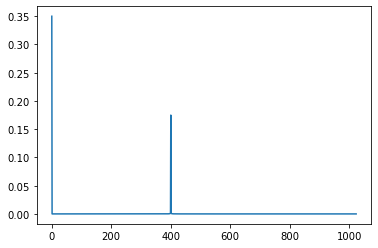

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile

A_c = float(0.6)
f_c = float(6000)
A_m = float(0.8)
f_m = float(400)
modulation_index = float(1)

sampling_rate = 51200
duration = 1
t = np.linspace(0, duration, sampling_rate)

carrier = A_c*np.cos(2*np.pi*f_c*t)
modulator = A_m*np.cos(2*np.pi*f_m*t)
product = A_c*(1+modulation_index*np.cos(2*np.pi*f_m*t))*np.cos(2*np.pi*f_c*t)

OUTPUTNAME = 'modulated_signal_noise.wav'
product = product / np.max(np.abs(product)) * 0.7
wavfile.write(OUTPUTNAME, sampling_rate, product)

t = np.arange(len(product)) / sampling_rate
f = np.linspace(0, sampling_rate, len(product))

analytic_signal = signal.hilbert(product)
amplitude_envelope = np.abs(analytic_signal)

ses = np.abs(np.fft.fft(amplitude_envelope) / len(product))
ses = ses[:int(len(product)/50)]
freqs = f[:int(len(product)/50)]

plt.plot(freqs, ses)